In [ ]:
#####################################################################
### Jupyter notebook should run at the root path of this project  ###
#####################################################################

In [2]:
import pandas as pd
import numpy as np
import platform as pf
import os
import xlrd

In [3]:
from matplotlib import pyplot as ppl
from sklearn import preprocessing as pprs
from scipy import stats
from datetime import datetime

In [4]:
pd.set_option("max_row",1000)
pd.set_option("max_column",10)

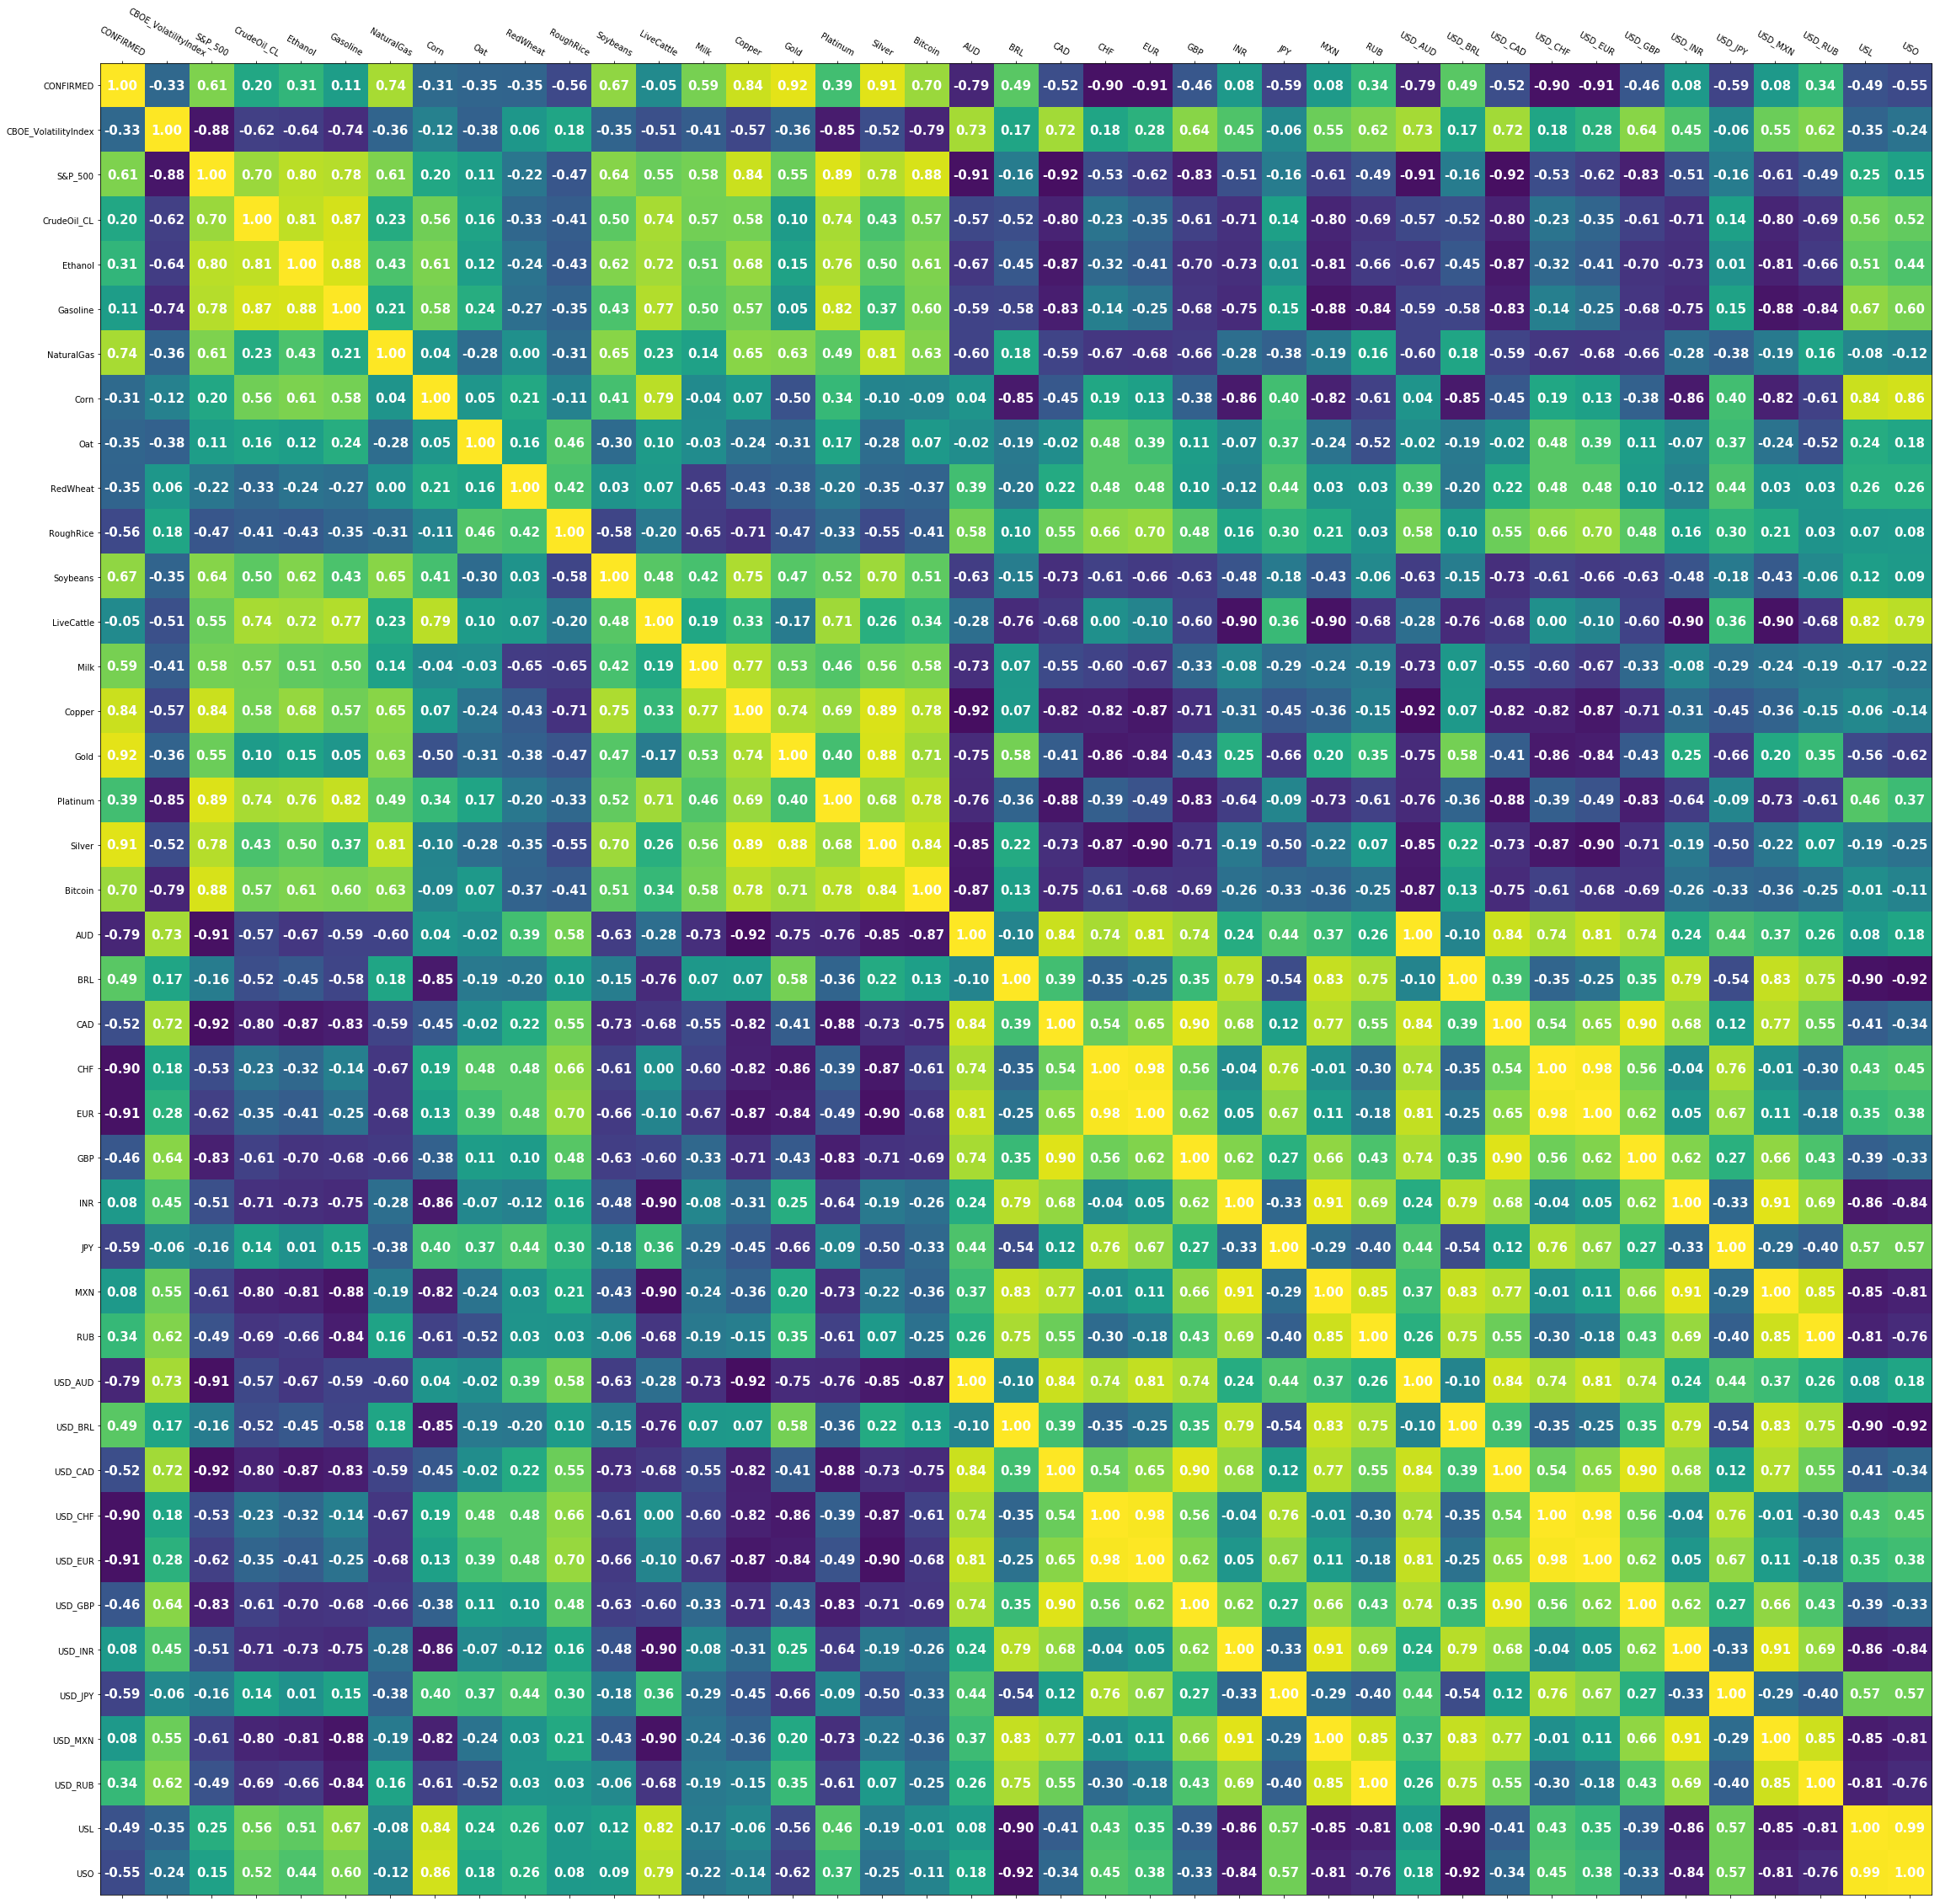

In [18]:
# Correlations between indicators
# Analyze correlations between all indicators
from pandas.plotting import scatter_matrix
def SimpleMultiFactor():
    covidDP = "../clean_data/covid-19/time_series_covid19_confirmed_global.csv"
    # Read confirmed data. Data is standardized into [0,1] using MinMaxScaler in order to observe the trend easier
    covidDF = pd.read_csv(covidDP)
    # covidDF_deaths = pd.read_csv(covidDP_deaths)
    covidDF["Date"] = pd.to_datetime(covidDF["Date"])
    date = covidDF["Date"].tolist()
    directories = ["Index","Commodities/Energies","Commodities/Grains","Commodities/Meats","Commodities/Metals","Cryptocurrencies","Currencies","Funds_ETFs"]
    # Files that not within consideration    
    exclusionFiles = ["DowJones_IndustrialAvg.csv","NASDAQ_100_ExTech.csv","NASDAQ_100_Index.csv",
                      "NASDAQ_100_Tech.csv","NASDAQ_Composite.csv","NASDAQ_CompositeIndex.csv",
                      "NYSE_Composite.csv","Russell_2000.csv","BinanceCoin.csv","BitcoinCash.csv",
                      "Cardano.csv","DASH.csv","Dogecoin.csv","EOS.csv","Ethereum.csv",
                      "EthereumClassic.csv","IOTA.csv","LiteCoin.csv","Monero.csv","NEM.csv",
                      "NEO.csv","Ripple.csv","Stellar.csv","Tether.csv","Tezos.csv","TRON.csv",
                      "VeChain.csv",    "CrudeOil_WTI_macrotrends.csv"]
    dataFP = "../clean_data/market/"
    completeDF = [covidDF["World"].tolist()]
    indicatorNames=["CONFIRMED"]
    counter = 1
    for directory in directories:
        rootPath = dataFP + directory
        plotNumber = 0
        for root, dirs, files in os.walk(rootPath):
            for file in files:
                path = os.path.join(root, file)
                if path.endswith('.csv'):
                    if file in exclusionFiles:
                        continue
                    indicatorData = pd.read_csv(path)
                    indicatorData["Date"] = pd.to_datetime(indicatorData["Date"])
                    indicatorData.sort_values('Date', inplace=True, ascending=True)
                    # Only keep data within the range of the covid data
                    indicatorData = indicatorData[(indicatorData["Date"] >= date[0]) & (indicatorData["Date"] <= date[-1])]
                    indicatorData = indicatorData[["Date", "Close/Last"]]
                    indicatorDate = indicatorData["Date"].tolist()
                    indicatorValue = indicatorData["Close/Last"].values
                    # Fill empty values in missing date. We use average value of nearest valid data point
                    i = 0
                    for j in range(0, len(date)):
                        if i >= len(indicatorDate):
                            newLine = pd.DataFrame({"Date":date[j], "Close/Last":indicatorValue[i - 1]}, index = [0])
                            indicatorData = indicatorData.append(newLine, ignore_index = True)
                        elif indicatorDate[i] > date[j]:
                            if i == 0:
                                newLine = pd.DataFrame({"Date":date[j], "Close/Last":indicatorValue[i]}, index = [0])
                            else:
                                insertValue = (indicatorValue[i] + indicatorValue[i - 1]) / 2
                                newLine = pd.DataFrame({"Date":date[j], "Close/Last":insertValue}, index = [0])
                            indicatorData = indicatorData.append(newLine, ignore_index = True)
                        else:
                            i += 1
                    indicatorData.sort_values('Date', inplace=True, ascending=True)
                    indicatorValue = indicatorData["Close/Last"].values
                    base = indicatorValue[0]
                    new_indicatorValue = []
                    # Value of each point will be transform to its percentage toward starting value
                    for each in indicatorValue:
                        if each / base < 1:
                            new_indicatorValue.append(-100.0 * (1 - each / base))
                        else:
                            new_indicatorValue.append(100.0 * (each / base - 1))
                    completeDF.append(new_indicatorValue)
                    counter += 1
                    indicatorNames.append(file.split(".")[0])
    completeDF = np.transpose(completeDF)
    completeDF = pd.DataFrame(completeDF) 
    completeDF.columns = indicatorNames
    result = completeDF.corr()
    # print(result)
    figure = ppl.figure(figsize=(40, 40))
    ax = figure.add_subplot(111)
    cax = ax.matshow(result, vmin=-1, vmax=1)
    ticks = np.arange(0, counter, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(indicatorNames)
    ax.set_yticklabels(indicatorNames)
    result_values = result.values
    rtext = {'color':  'white', 'weight': 'bold', 'size': 15}
    for x in range(0, result.shape[0]):
        for y in range(0, result.shape[0]):
            ax.text(x, y, '%.2f'%result_values[x][y], va='center', ha='center', fontdict=rtext)
    ppl.xticks(rotation = -30)
    # If not exist, create folder 'result'
    if not os.path.exists("../result"):
        os.makedirs("../result")
        print("directory 'result' created")
    ppl.savefig("../result/CorrelationsAll_P.png")
    ppl.show()
SimpleMultiFactor()
    